这个笔记本使用原生 Python 绑定，为 MuJoCo 物理提供了一个入门教程
摘自：https://github.com/google-deepmind/mujoco/blob/main/python/tutorial.ipynb

# All imports

In [1]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# Example: A chaotic pendulum 示例：混沌摆

""

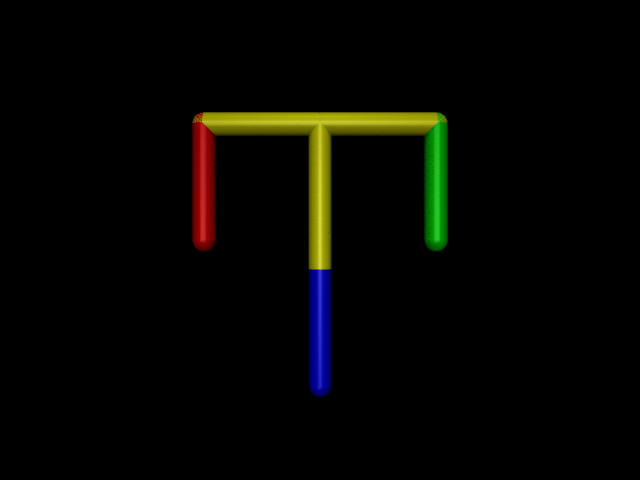

In [2]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
# 从xml字符串中加载模型
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
# 创建数据对象
data = mujoco.MjData(model)

# 设置渲染图像的分辨率
height = 480
width = 640

# 创建渲染器上下文
with mujoco.Renderer(model, height, width) as renderer:
    mujoco.mj_forward(model, data)  # 进行一次正运动学计算，更新位置
    # void mj_forward(const mjModel* m, mjData* d);:正向运动学：与mj_step相同，但不进行时间积分
    renderer.update_scene(data, camera="fixed")  # 使用固定相机更新场景

    # 渲染并显示图片
    media.show_image(renderer.render())

## Timing 计时

In [3]:
# setup  # 预处理及设置参数
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state  # 设置初始状态
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames  # 进行模拟并记录帧
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):
        while data.time * framerate < i:
            tic = time.time()
            mujoco.mj_step(model, data)
            sim_time += time.time() - tic
            n_steps += 1

        # 渲染当前帧
        tic = time.time()
        renderer.update_scene(data, "fixed")
        frame = renderer.render()
        render_time += time.time() - tic
        frames.append(frame)

# print timing and play video  # 打印时间并播放视频
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video  # 播放视频
media.show_video(frames, fps=framerate)

simulation:  1.44 μs/step  (692839Hz)
rendering:    216 μs/frame ( 4619Hz)




## Chaos 混沌

/tmp/ipykernel_143880/567113803.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle[i] = data.joint('root').qpos


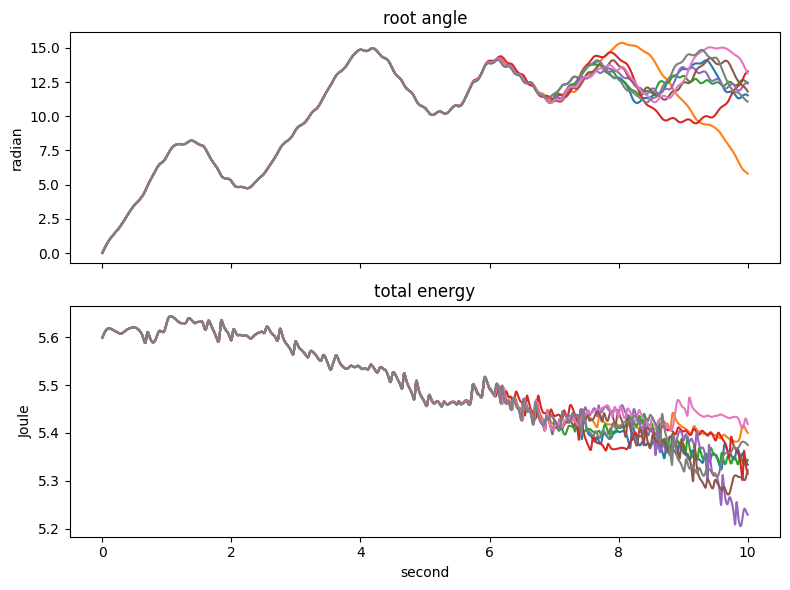

In [4]:
# 设置仿真参数
PERTURBATION = 1e-7  # 初始速度扰动量（模拟初值敏感性）
SIM_DURATION = 10  # 仿真总时长（秒）
NUM_REPEATS = 8  # 仿真次数（每次初值微扰）

# preallocate  # 预分配内存
n_steps = int(SIM_DURATION / model.opt.timestep)  # 每次仿真的步数
sim_time = np.zeros(n_steps)  # 记录仿真时间
angle = np.zeros(n_steps)  # 记录根关节角度
energy = np.zeros(n_steps)  # 记录总能量

# prepare plotting axes  # 绘图准备
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions  # 多次仿真，每次扰动初始条件
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)  # 重置模型状态
  data.qvel[0] = 10 # root joint velocity  # root关节初始角速度
  # perturb initial velocities  # 初始扰动
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate  # 逐步仿真
  for i in range(n_steps):
    mujoco.mj_step(model, data)  # 执行一步仿真
    sim_time[i] = data.time  # 当前时间
    angle[i] = data.joint('root').qpos  # 记录root环节角度
    energy[i] = data.energy[0] + data.energy[1]  # 系统总能量

  # plot  # 绘图
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot  # 最终完成绘图
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

## Timestep and accuracy 时间步长和精度

1000 steps at dt = 10ms
3162 steps at dt = 3.2ms
10000 steps at dt =  1ms
31622 steps at dt = 0.32ms
100000 steps at dt = 0.1ms


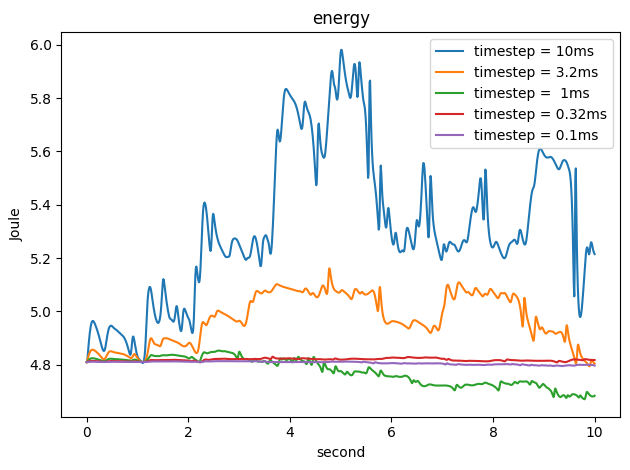

In [5]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

## Timestep and divergence 时间步长和发散

simulating 1000 steps at dt = 10ms
stopped due to divergence (mjWARN_BADQACC) at timestep 385.

simulating 825 steps at dt = 12ms
stopped due to divergence (mjWARN_BADQACC) at timestep 322.

simulating 681 steps at dt = 15ms
stopped due to divergence (mjWARN_BADQACC) at timestep 166.

simulating 562 steps at dt = 18ms
stopped due to divergence (mjWARN_BADQACC) at timestep 105.

simulating 464 steps at dt = 22ms
stopped due to divergence (mjWARN_BADQACC) at timestep 84.

simulating 383 steps at dt = 26ms
stopped due to divergence (mjWARN_BADQACC) at timestep 61.

simulating 316 steps at dt = 32ms
stopped due to divergence (mjWARN_BADQACC) at timestep 45.



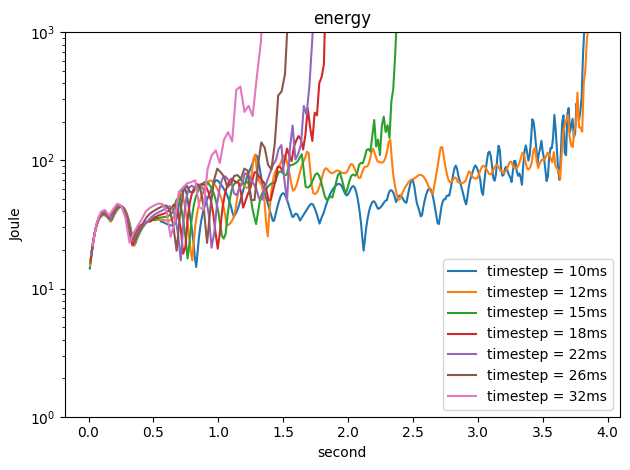

In [6]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
  # set timestep
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 11 # set root joint velocity

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    if data.warning.number.any():
      warning_index = np.nonzero(data.warning.number)[0][0]
      warning = mujoco.mjtWarning(warning_index).name
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')
      break
    sim_time[i] = data.time
    energy[i] = sum(abs(data.qvel))
    speed[i] = np.linalg.norm(data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')

# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()